Starting Minority Game Simulation...
Parameters: m=5, s=2, iterations=1000, equilibrium period=200

=== Simulation Results ===
Format: N | 2^m/N | σ²/N (mean ± std) | Avg Buyers | Last Buyers
----------------------------------------------------------------------
N= 21 | 1.524 | 0.078 ± 0.010 | 10.4 | 10.6
N= 36 | 0.889 | 0.003 ± 0.002 | 18.0 | 18.0
N= 51 | 0.627 | 0.062 ± 0.003 | 25.5 | 25.4
N= 66 | 0.485 | 0.003 ± 0.002 | 33.0 | 33.0
N= 81 | 0.395 | 0.058 ± 0.004 | 40.5 | 39.2
N= 96 | 0.333 | 0.013 ± 0.010 | 48.0 | 48.0
N=111 | 0.288 | 0.143 ± 0.020 | 55.5 | 55.5
N=126 | 0.254 | 0.026 ± 0.010 | 63.0 | 63.0
N=141 | 0.227 | 0.238 ± 0.020 | 70.5 | 69.1
N=156 | 0.205 | 0.049 ± 0.030 | 78.0 | 77.4
N=171 | 0.187 | 0.289 ± 0.017 | 85.5 | 81.6
N=186 | 0.172 | 0.191 ± 0.047 | 93.0 | 92.8
N=201 | 0.159 | 0.419 ± 0.013 | 100.5 | 103.7
N=216 | 0.148 | 0.282 ± 0.063 | 108.0 | 106.5
N=231 | 0.139 | 0.453 ± 0.010 | 115.5 | 109.1

Theoretical optimal 2^m/N ratio: 0.34
Observed optimal 2^m/N ratio: 0.

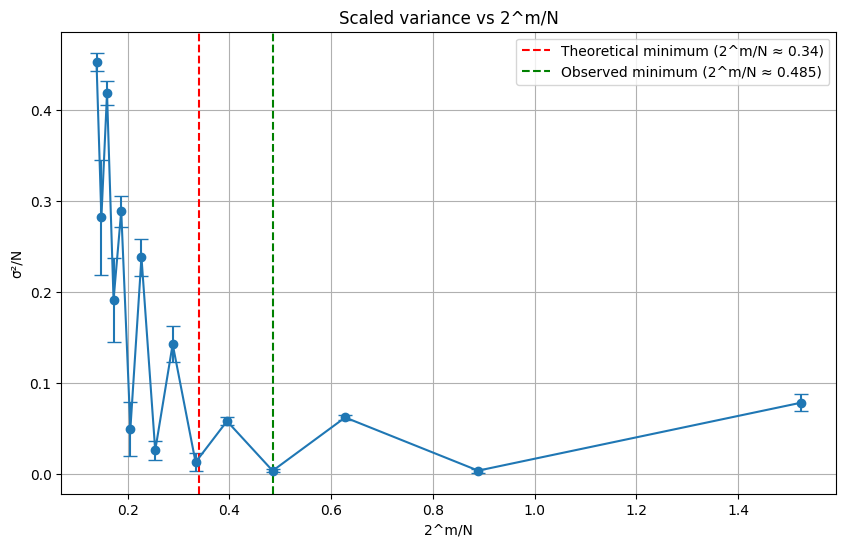

In [9]:
import numpy as np
import matplotlib.pyplot as plt


class MinorityGame:
    def __init__(self, m=5, s=2, iter=1000, iteq=200):
        self.m = m
        self.s = s
        self.iter = iter
        self.iteq = iteq

    def simulate_once(self, N):
        agents = [Agent(self.m, self.s) for _ in range(N)]
        state = 0
        buyers_count = []

        for t in range(self.iter):
            actions = []
            chosen_strategies = []
            for agent in agents:
                action, strategy_idx = agent.choose_action(state)
                actions.append(action)
                chosen_strategies.append(strategy_idx)
            
            actions = np.array(actions)
            buyers = np.sum(actions == 1)
            excess_demand = 2 * buyers - N

            for i, agent in enumerate(agents):
                for j in range(self.s):
                    prediction = agent.strategies[j].predict(state)
                    agent.virtual_scores[j] += -prediction * excess_demand / N
                
                agent.real_score += -actions[i] * excess_demand / N

            state = (((state << 1) & ((2**self.m)-1)) | (1 if excess_demand > 0 else 0))

            if t >= self.iteq:
                buyers_count.append(buyers)

        variance = np.var(buyers_count)
        return variance, buyers_count[-1], np.mean(buyers_count)

    def run_simulation(self):
        N_values = np.linspace(21, 231, 15).astype(int)
        nsam = 10  

        results = []
        errors = []
        x_values = []

        print("\n=== Simulation Results ===")
        print("Format: N | 2^m/N | σ²/N (mean ± std) | Avg Buyers | Last Buyers")
        print("-" * 70)

        for N in N_values:
            variances = []
            avg_buyers_list = []
            last_buyers_list = []
            
            for sample in range(nsam):
                variance, last_buyers, avg_buyers = self.simulate_once(N)
                variances.append(variance/N)
                avg_buyers_list.append(avg_buyers)
                last_buyers_list.append(last_buyers)
            
            mean_variance = np.mean(variances)
            std_variance = np.std(variances)/np.sqrt(nsam)
            mean_avg_buyers = np.mean(avg_buyers_list)
            mean_last_buyers = np.mean(last_buyers_list)
            
            results.append(mean_variance)
            errors.append(std_variance)
            x_value = 2**self.m/N
            x_values.append(x_value)

            print(f"N={N:3d} | {x_value:.3f} | {mean_variance:.3f} ± {std_variance:.3f} | "
                  f"{mean_avg_buyers:.1f} | {mean_last_buyers:.1f}")

        print("\nTheoretical optimal 2^m/N ratio: 0.34")
        min_index = np.argmin(results)
        print(f"Observed optimal 2^m/N ratio: {x_values[min_index]:.3f}")
        print(f"Minimum scaled variance: {results[min_index]:.3f} ± {errors[min_index]:.3f}")

        self.plot_results(x_values, results, errors)
        return x_values, results, errors

    def plot_results(self, x_values, results, errors):
        plt.figure(figsize=(10, 6))
        plt.errorbar(x_values, results, yerr=errors, fmt='o-', capsize=5)
        plt.xlabel('2^m/N')
        plt.ylabel('σ²/N')
        plt.title('Scaled variance vs 2^m/N')
        plt.grid(True)

        plt.axvline(x=0.34, color='r', linestyle='--', 
                   label='Theoretical minimum (2^m/N ≈ 0.34)')
        
        min_index = np.argmin(results)
        min_x = x_values[min_index]
        plt.axvline(x=min_x, color='g', linestyle='--', 
                   label=f'Observed minimum (2^m/N ≈ {min_x:.3f})')
        
        plt.legend()
        plt.show()

def main():
    np.random.seed(42)
    print("Starting Minority Game Simulation...")
    print(f"Parameters: m=5, s=2, iterations=1000, equilibrium period=200")
    
    game = MinorityGame(m=5, s=2, iter=1000, iteq=200)
    game.run_simulation()

if __name__ == "__main__":
    main()